In [1]:
import pandas as pd
import numpy as np

from src.OLS import OLS
from src.StandardScaler import StandardScaler

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import seaborn as sns

from src.stat_tests import KS2Sample, AR1, BootstrapKS2Samp, VIF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_ccf

c:\Users\guney\Documents\GitHub\Econometrics2025-Project\src\stat_tests.py:335: SyntaxWarning: invalid escape sequence '\m'
  nr_template = lambda x, y: f"Fail to Reject $\mathbf{{H_0}}$ \n $p={x:.4f}$ \n $C = {y:.4f}$"
c:\Users\guney\Documents\GitHub\Econometrics2025-Project\src\stat_tests.py:336: SyntaxWarning: invalid escape sequence '\m'
  r_template = lambda x, y: f"Reject $\mathbf{{H_0}}$\n $p={x:.4f}$ \n $C = {y:.4f}$"
c:\Users\guney\Documents\GitHub\Econometrics2025-Project\src\stat_tests.py:451: SyntaxWarning: invalid escape sequence '\m'
  nr_template = lambda x, y: f"Fail to Reject $\mathbf{{H_0}}$ \n $p={x:.4f}$ \n $C = {y:.4f}$"
c:\Users\guney\Documents\GitHub\Econometrics2025-Project\src\stat_tests.py:452: SyntaxWarning: invalid escape sequence '\m'
  r_template = lambda x, y: f"Reject $\mathbf{{H_0}}$\n $p={x:.4f}$ \n $C = {y:.4f}$"


In [2]:
s = StandardScaler()
rgdp = pd.read_csv('./data/fred/GDPC1.csv', low_memory=False, encoding='utf-8')
tcu = pd.read_csv('./data/fred/CPIAUCSL.csv', low_memory=False, encoding='utf-8')
unrate = pd.read_csv('./data/fred/UNRATE.csv', low_memory=False, encoding='utf-8')

set = [rgdp, tcu, unrate]
for df in set:
    df.set_index("observation_date", inplace=True)


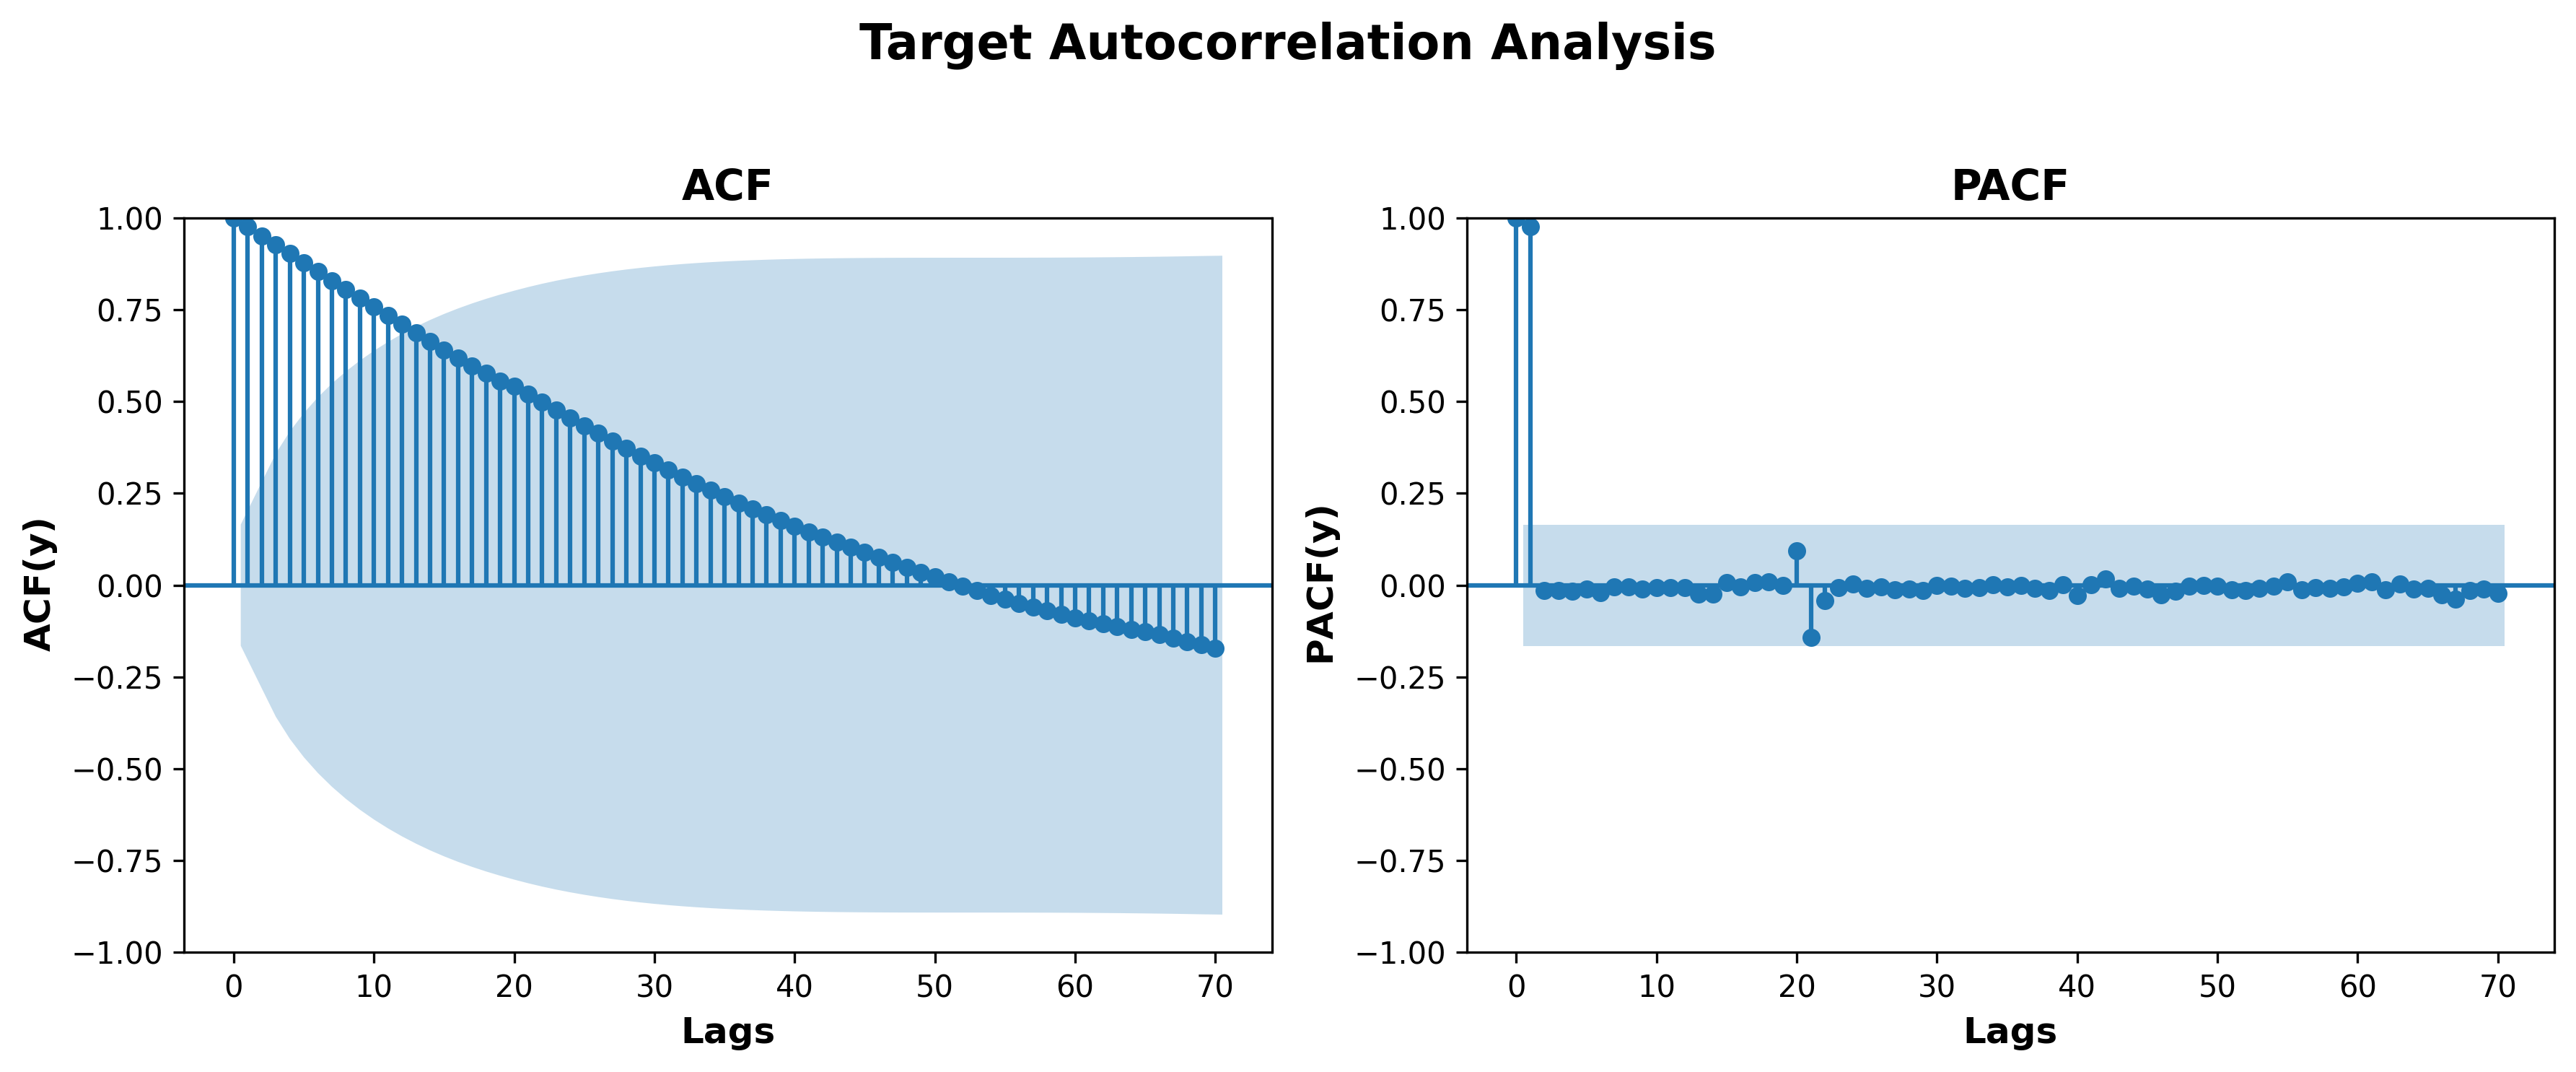

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(rgdp, ax[0], lags=70)
ax[0].set_title(r"ACF", fontsize=14, weight='bold')
ax[0].set_xlabel(r"Lags", fontsize=12, weight='bold')
ax[0].set_ylabel(r"$\mathbf{ACF(y)}$", fontsize=12, weight='bold')

plot_pacf(rgdp, ax[1], lags=70)
ax[1].set_title(r"PACF", fontsize=14, weight='bold')
ax[1].set_xlabel(r"Lags", fontsize=12, weight='bold')
ax[1].set_ylabel(r"$\mathbf{PACF(y)}$", fontsize=12, weight='bold')
plt.suptitle(r"Target Autocorrelation Analysis", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig('./paper/fig/acf_pacf.png', dpi=300)
plt.show()


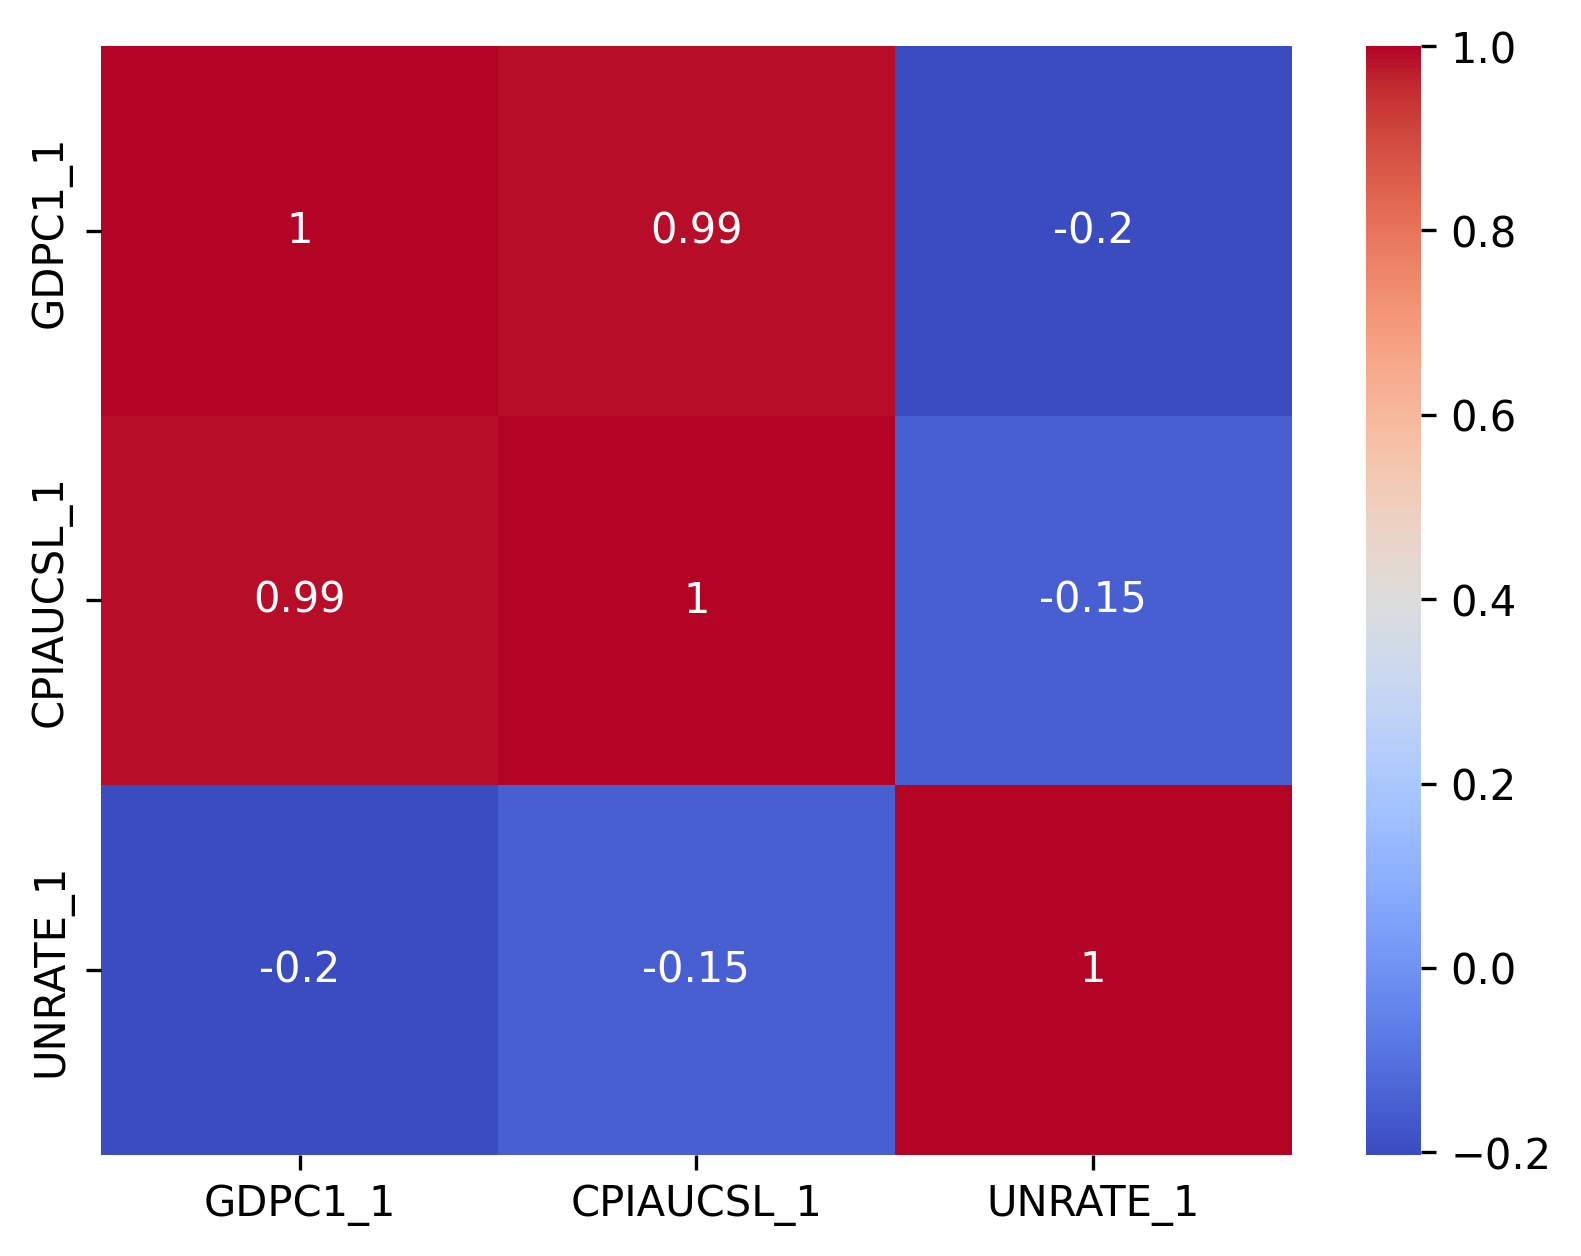

In [4]:
target = pd.Series(rgdp['GDPC1'])
X = pd.concat([rgdp, tcu.loc[rgdp.index], unrate.loc[rgdp.index]], axis=1)
X = X.shift(1).dropna(how='any')
cols = X.columns.tolist()
X.columns = [col + "_1" for col in cols]
X_2 = X.shift(1)

target = target.loc[X.index]

assert X.notna().all().all() == target.notna().all().all() == True, len(X) == len(target)
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')

y = target.values
X = s.fit_transform(X.values)

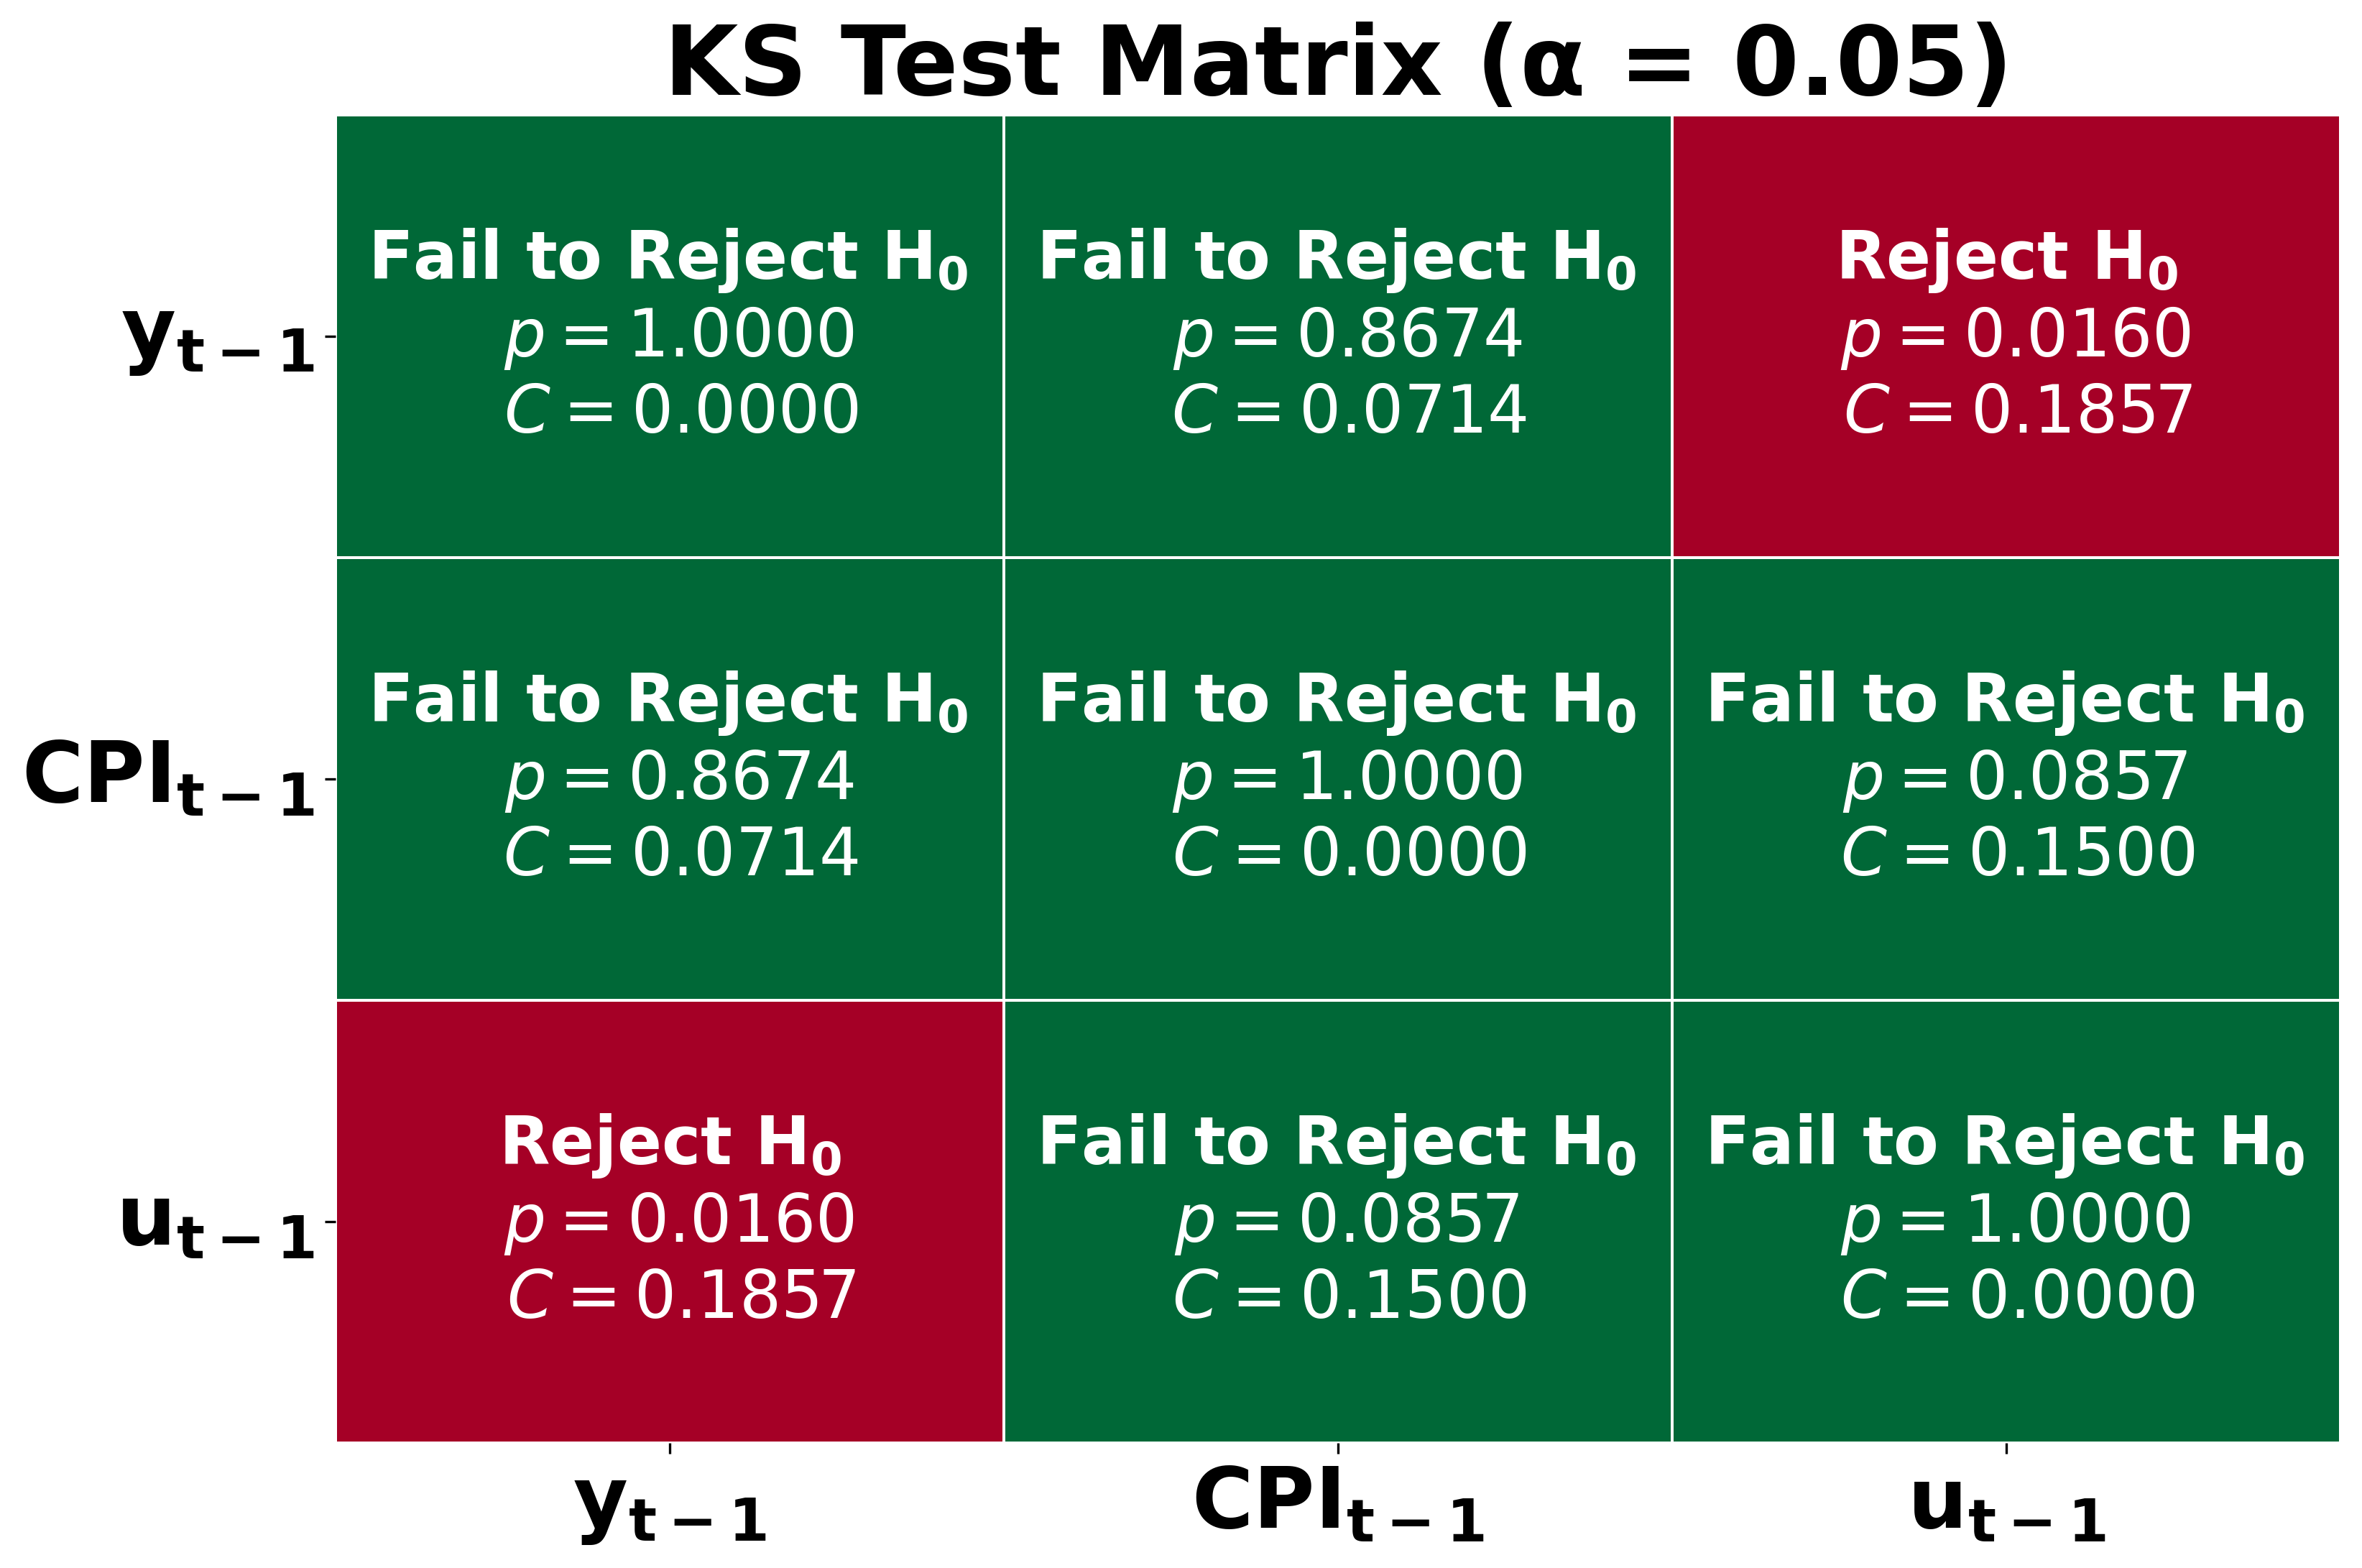

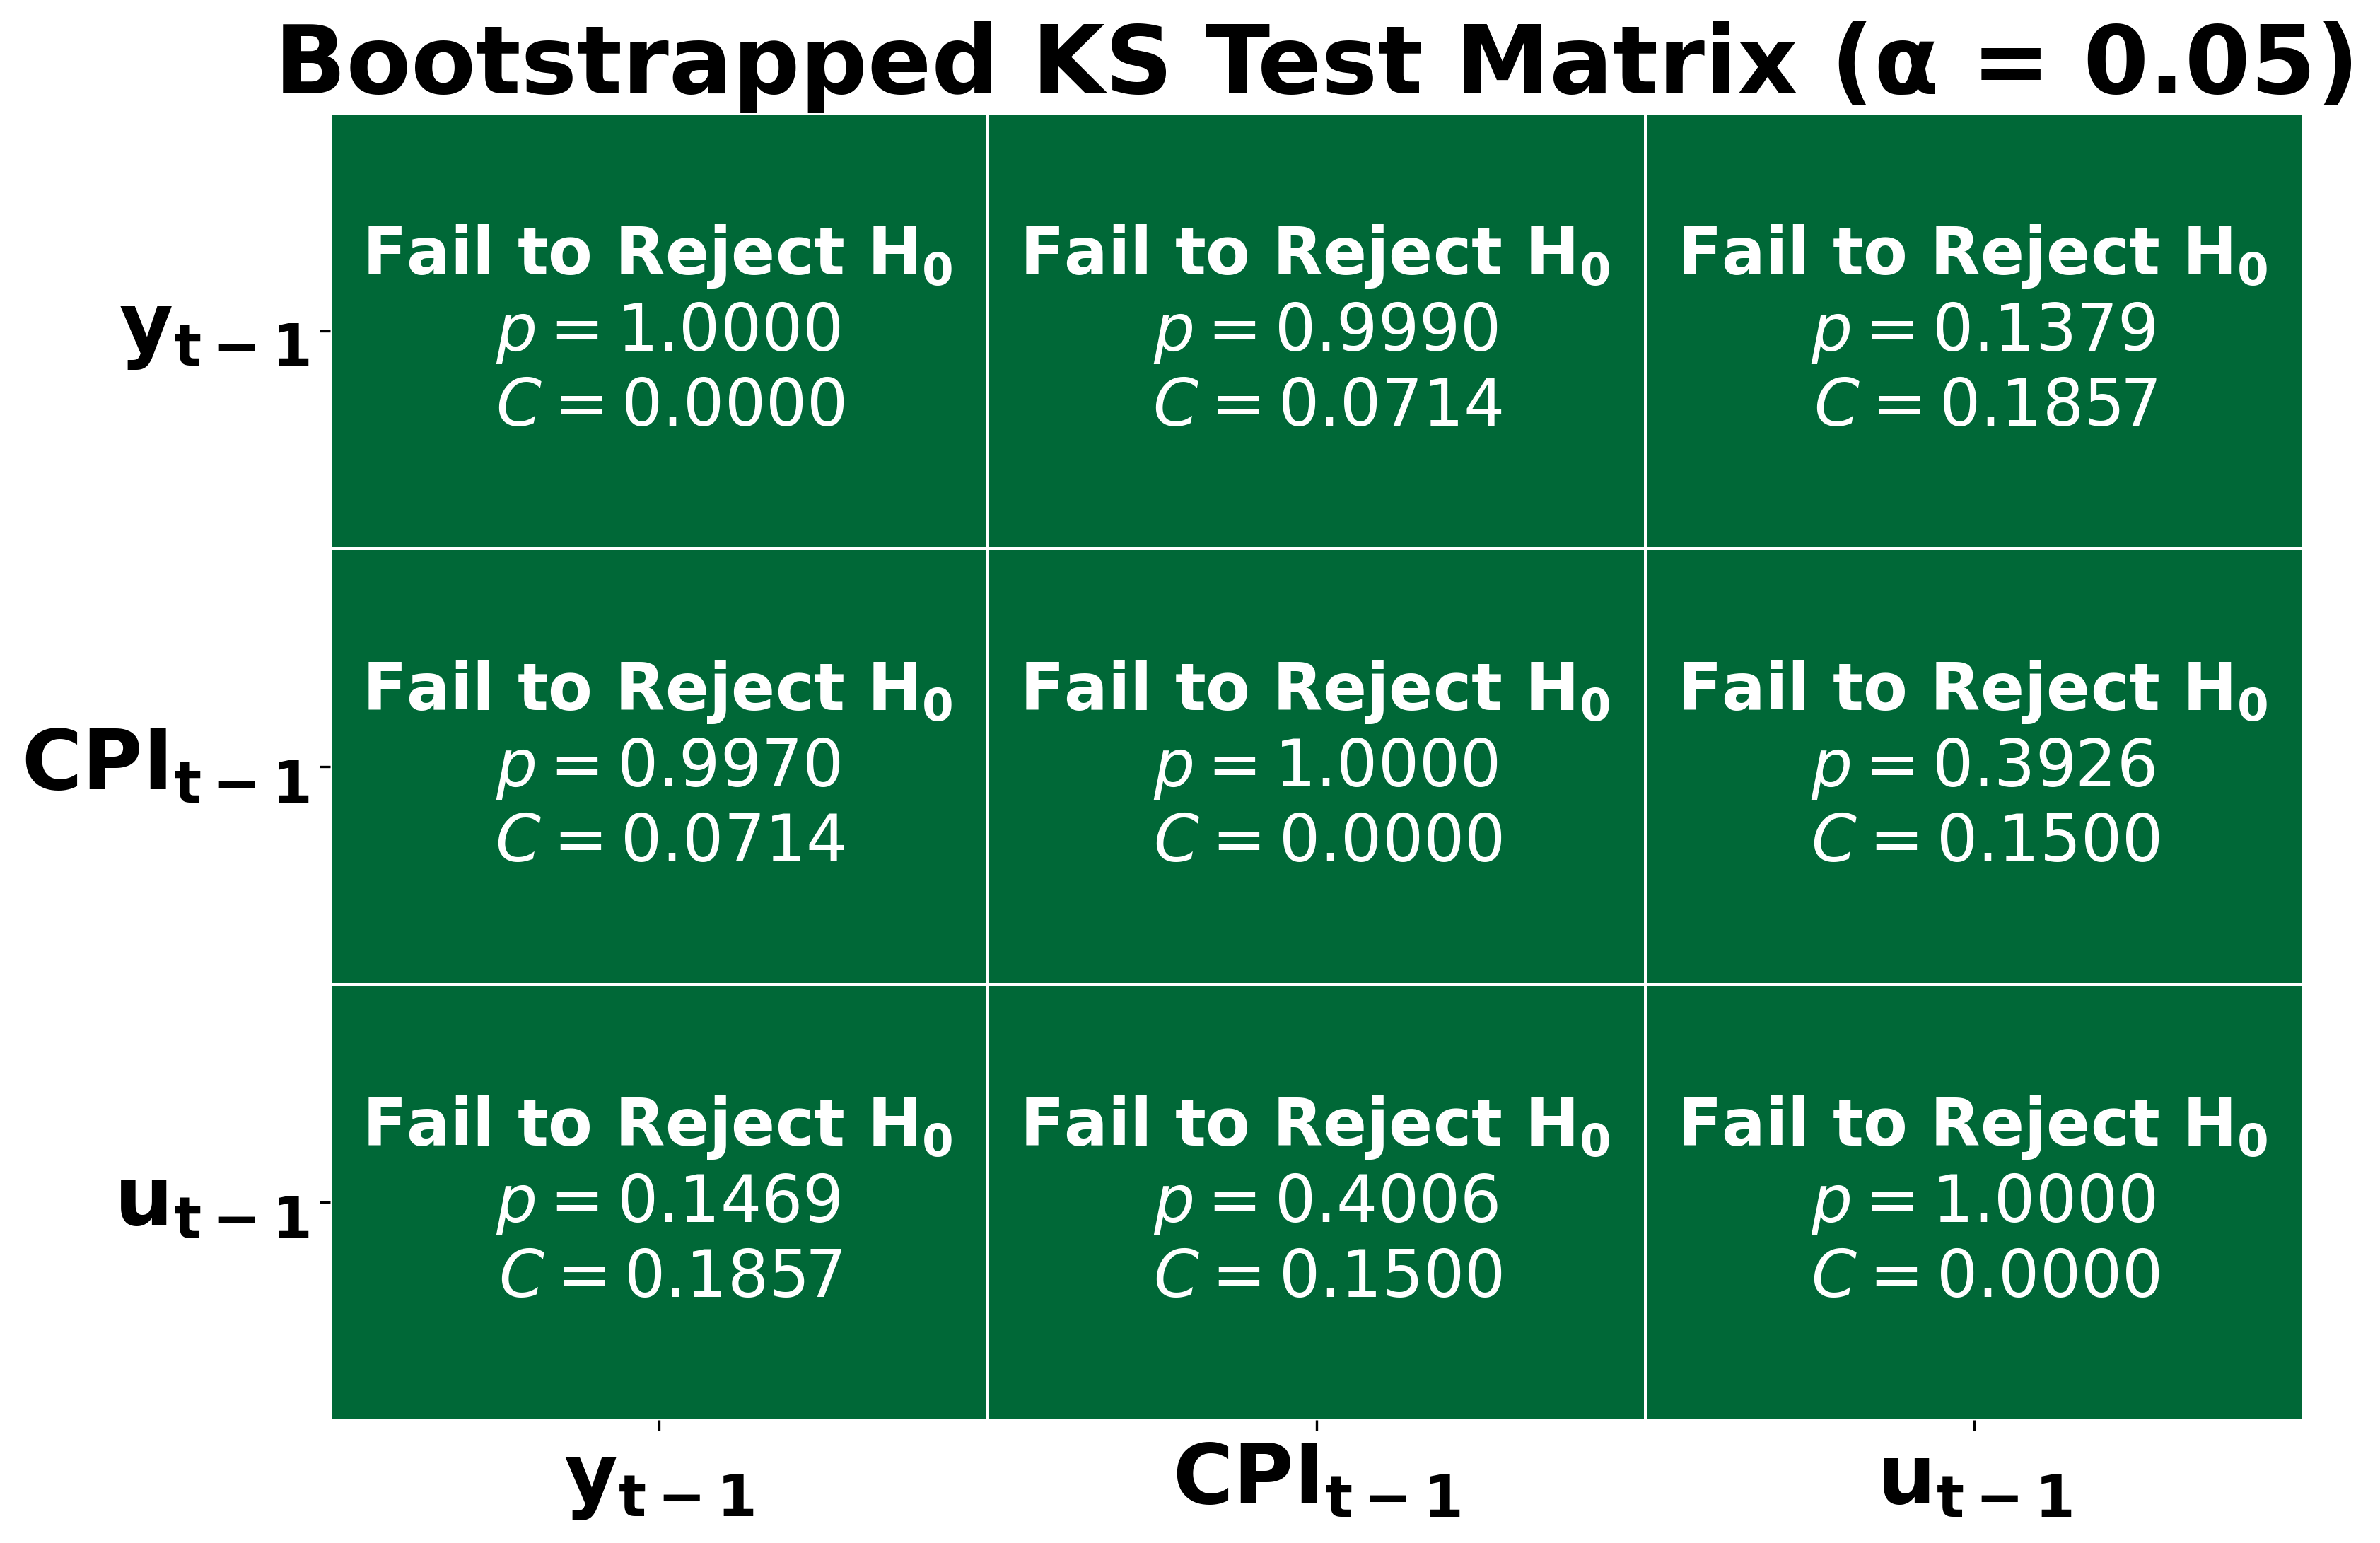

In [5]:
vars = [r"$\mathbf{y_{t-1}}$", r"$\mathbf{CPI_{t-1}}$", r"$\mathbf{u_{t-1}}$"]
tests = KS2Sample(X, display_plot=True, varnames=vars)
bs_tests = BootstrapKS2Samp(X, display_plot=True, n_bootstrap=1000, varnames=vars)

In [6]:
tests[0]

,$y_{t-1}$,$CPI_{t-1}$,$u_{t-1}$
$y_{t-1}$,0.000000,0.071429,0.185714
$CPI_{t-1}$,0.071429,0.000000,0.150000
$u_{t-1}$,0.185714,0.150000,0.000000


In [22]:
VIF(X[:, 1:])

array([1.02258087, 1.02258087])

In [8]:
u_ar = AR1(X[:, 2], "n")
u_resid = X[1:, 2] - u_ar * X[:-1, 2]
u_target = X[1:, 0] - u_ar * X[:-1, 0]

cpi_ar = AR1(X[:, 1], "n")
cpi_resid = X[1:, 1] - cpi_ar * X[:-1, 1]
cpi_target = X[1:, 0] - cpi_ar * X[:-1, 0]

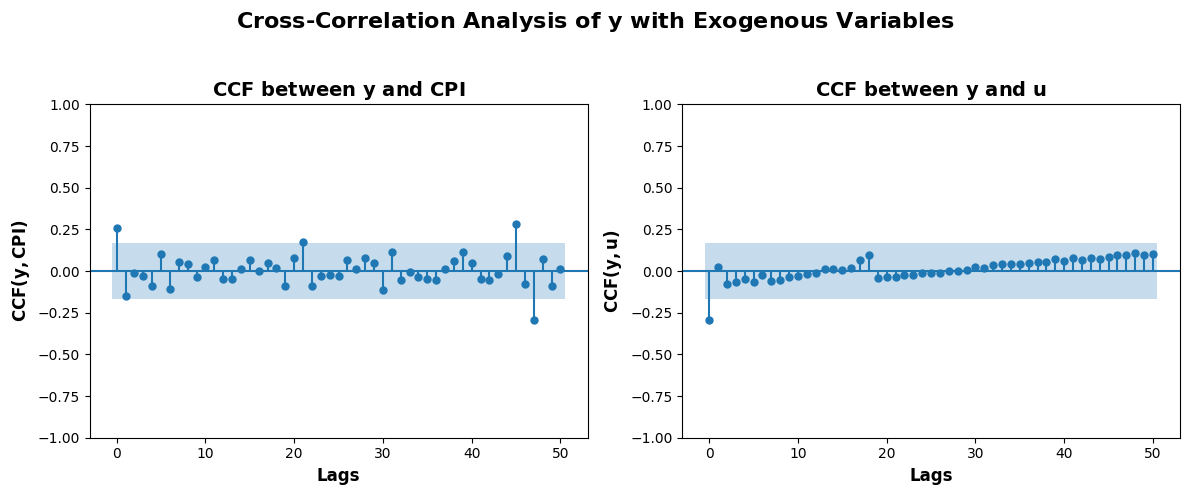

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_ccf(cpi_target, cpi_resid, ax=ax[0], lags=50)
ax[0].set_title(r"CCF between $\mathbf{y}$ and $\mathbf{CPI}$", fontsize=14, weight='bold')
ax[0].set_xlabel(r"Lags", fontsize=12, weight='bold')
ax[0].set_ylabel(r"$\mathbf{CCF(y, CPI)}$", fontsize=12, weight='bold')

plot_ccf(u_target, u_resid, ax=ax[1], lags=50)
ax[1].set_title(r"CCF between $\mathbf{y}$ and $\mathbf{u}$", fontsize=14, weight='bold')
ax[1].set_xlabel(r"Lags", fontsize=12, weight='bold')
ax[1].set_ylabel(r"$\mathbf{CCF(y, u)}$", fontsize=12, weight='bold')

plt.suptitle(r"Cross-Correlation Analysis of $\mathbf{y}$ with Exogenous Variables", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig('./paper/fig/ccf.png', dpi=300)
plt.show()

In [10]:
# Lagged Exog correlations
corr_df = pd.concat([target, tcu, unrate], axis=1)
corr_df.columns = ['y', 'CPI_0', 'u_0']
for lag in range(1, 6):
    corr_df[f'CPI_{lag}'] = tcu.shift(lag)
    corr_df[f'u_{lag}'] = unrate.shift(lag)
corr_df.dropna(inplace=True)
corr_df.corr()['y']


y        1.000000
CPI_0    0.988544
u_0     -0.220881
CPI_1    0.988428
u_1     -0.254530
CPI_2    0.988302
u_2     -0.221107
CPI_3    0.988282
u_3     -0.189661
CPI_4    0.988269
u_4     -0.236069
CPI_5    0.988225
u_5     -0.205095
Name: y, dtype: float64

In [11]:
X_fit = X
y_fit = y

ols = OLS(X_fit, y_fit)
fit = ols.fit(diagnosis_trend="n")
fit.XT_e, fit.beta, fit.coefs, fit.intercept

(np.float64(-6.246381190067041e-09),
 array([1.62572699e+04, 3.79425420e+03, 1.48270887e+01, 6.55375880e+01]),
 array([3794.25419981,   14.82708874,   65.53758803]),
 np.float64(16257.2699))

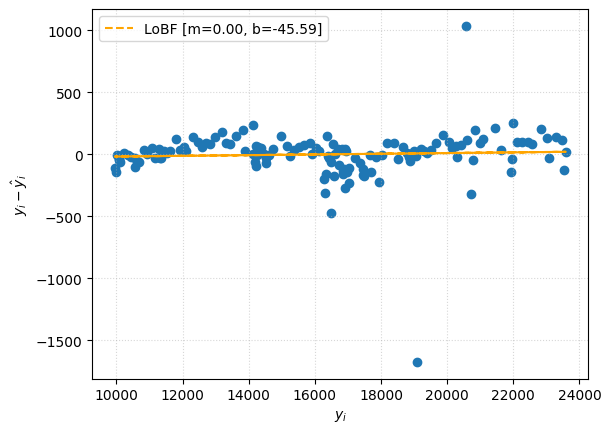

In [12]:
n = len(fit.resid)
m, b = np.polyfit(y_fit, fit.resid, 1)

line = m * y_fit + b


plt.scatter(y_fit, fit.resid)
plt.plot(y_fit, line, label=f"LoBF [{m=:.2f}, {b=:.2f}]", linestyle="--", color="orange")

plt.xlabel(r"$y_i$")
plt.ylabel(r"$y_i - \hat{y}_i$")

plt.grid(alpha=0.5, linestyle=":")

plt.legend()
plt.show()

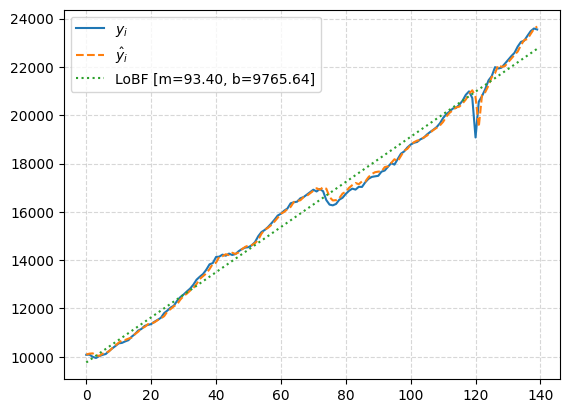

In [13]:
x = np.array([i for i in range(len(y_fit))])
m, b = np.polyfit(x, y_fit, 1)
plt.plot(x, y_fit, label=r"$y_i$")
plt.plot(x, fit.fitted_values, label=r"$\hat{y}_i$", linestyle="--")
plt.plot(x, m*x + b, label=f"LoBF [{m=:.2f}, {b=:.2f}]", linestyle=":")

plt.grid(alpha=0.5, linestyle="--")
plt.legend()
plt.show()

In [14]:
fit.resid_heteroske

reject: False
pval: 0.7251644186679356
test_stat: 3.8789493781726048
stat_name: Breusch-Pagan Test (Chi^2 Statistic)

In [15]:
# print(ols.predict(X_test))
fit.resid_normality

reject: True
pval: 1.8140715685177315e-17
test_stat: 0.6202241732552098
stat_name: Shapiro-Wilk Test (Approximated Z-Statistic)

In [16]:
fit.resid_stationarity

reject: True
pval: 0.023310063676103943
test_stat: -2.2532947304191593
stat_name: ADF Test (T-Statistic)

In [17]:
fit.resid_autocorr
all(t.reject == False for t in fit.resid_autocorr)

True

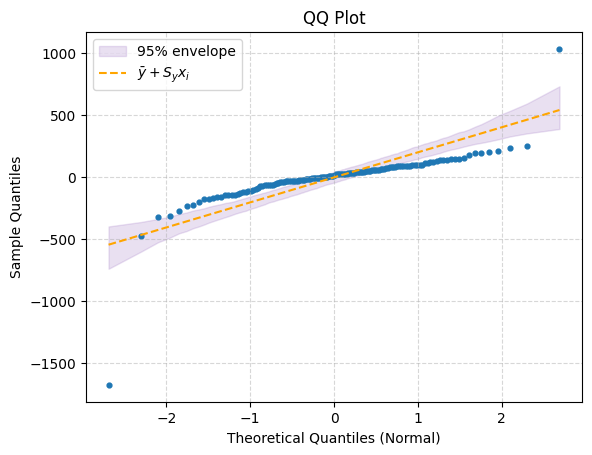

In [18]:
fit.qq(line="45", band=0.95)

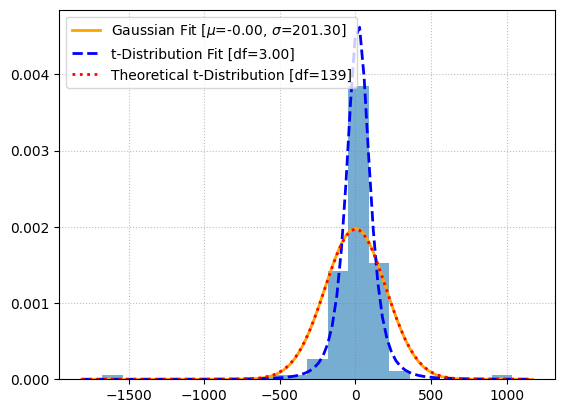

(np.float64(2.3637332835189726),
 np.float64(17.141721644851884),
 np.float64(78.7582292950595))

In [19]:
from scipy.stats import norm, t
plt.hist(fit.resid, bins=20, density=True, alpha=0.6)
mu, std = norm.fit(fit.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

ts = t.fit(fit.resid)
t_fitted = t.pdf(x, ts[0] + .64, ts[1], ts[2])

df = len(fit.resid) - 1
sig = np.std(fit.resid, ddof=1)
mu = np.mean(fit.resid)
t_theoretical = t.pdf(x, df, mu, sig)

plt.plot(x, p,linewidth=2, label=rf"Gaussian Fit [$\mu$={mu:.2f}, $\sigma$={std:.2f}]", color="orange", linestyle="-")
plt.plot(x, t_fitted, linewidth=2, label=rf"t-Distribution Fit [df={ts[0] + .64:.2f}]", linestyle="--", color="blue")
plt.plot(x, t_theoretical, linewidth=2, label=rf"Theoretical t-Distribution [df={df}]", linestyle=":", color="red")

plt.grid(alpha=0.5, linestyle=":", color="gray")
plt.legend()
plt.show()

ts

In [20]:
unrate.describe()

,UNRATE
count,421.000000
mean,5.710689
std,1.748416
min,3.400000
25%,4.400000
50%,5.400000
75%,6.600000
max,14.800000
